<a href="https://colab.research.google.com/github/skytecat/FraudDetection/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЧТО СДЕЛАТЬ/ПРОВЕРИТЬ:

- графики распределения данных?
- подумать над тем, нужно ли обрабатывать выбросы
- возможно стоит забить на подбор порога и вместо этого смотреть на AUPRC и подбирать гиперпараметры тоже максимизируя AUPRC
- сохранить модель с предобработкой
- выбрать способ масштабирования для data['Amount']
- изменить везде точность на :.3f
- поставить везде одинаковый max_iter или убрать вообще
- посмотреть на методы оптимизации
lbfgs: Хороший выбор по умолчанию, часто сходится быстро.
liblinear: Подходит для небольших датасетов, может требовать больше итераций.
saga: Поддерживает L1-регуляризацию, может быть медленнее.
- random_state везде проверить

без масштабирования

первичная оценка:
f1: 0.7216978587773782
recall: 0.6188070175438597
precision: 0.8709508735241508

итоговая:
F1 Score for test with Optimal Threshold: 0.7955801104972375
Precision Score for test with Optimal Threshold: 0.8372093023255814
Recall Score for test with Optimal Threshold: 0.7578947368421053

с масштабированием всех V Standart Scaler

первичная оценка:
score for train data:
f1: 0.7191044190790256
recall: 0.6214385964912281
precision: 0.8595816954437645

итоговая:
F1 Score for test with Optimal Threshold: 0.7912087912087912
Precision Score for test with Optimal Threshold: 0.8275862068965517
Recall Score for test with Optimal Threshold: 0.7578947368421053

Robust для всего

первичная оценка:
score for train data:
f1: 0.7177291519632092
recall: 0.6081052631578947
precision: 0.8828562011257871

итоговая:
F1 Score for test with Optimal Threshold: 0.7912087912087912
Precision Score for test with Optimal Threshold: 0.8275862068965517
Recall Score for test with Optimal Threshold: 0.7578947368421053

## Загрузка и анализ данных

### Импорт библиотек

In [3]:
# Базовые библиотеки для работы с данными
import pandas as pd
import numpy as np

# Визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# Предобработка данных
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression

# Оценка модели и подбор гиперпараметров
from sklearn.model_selection import (
     cross_val_score,
     GridSearchCV,
     cross_val_predict,
     StratifiedKFold
)
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    make_scorer,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# Методы балансировки данных
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### Загрузка данных

In [4]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Размер данных

In [ ]:
data.shape

(284807, 31)

### Типы признаков

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Пропущенные значения

In [ ]:
# Подсчет пропусков в каждом столбце
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


### Анализ распределений числовых признаков

In [ ]:
data.describe()

NameError: name 'data' is not defined

In [ ]:
data[['Time', 'Amount']].describe()

,Time,Amount
count,283726.000000,283726.000000
mean,94811.077600,88.472687
std,47481.047891,250.399437
min,0.000000,0.000000
25%,54204.750000,5.600000
50%,84692.500000,22.000000
75%,139298.000000,77.510000
max,172792.000000,25691.160000


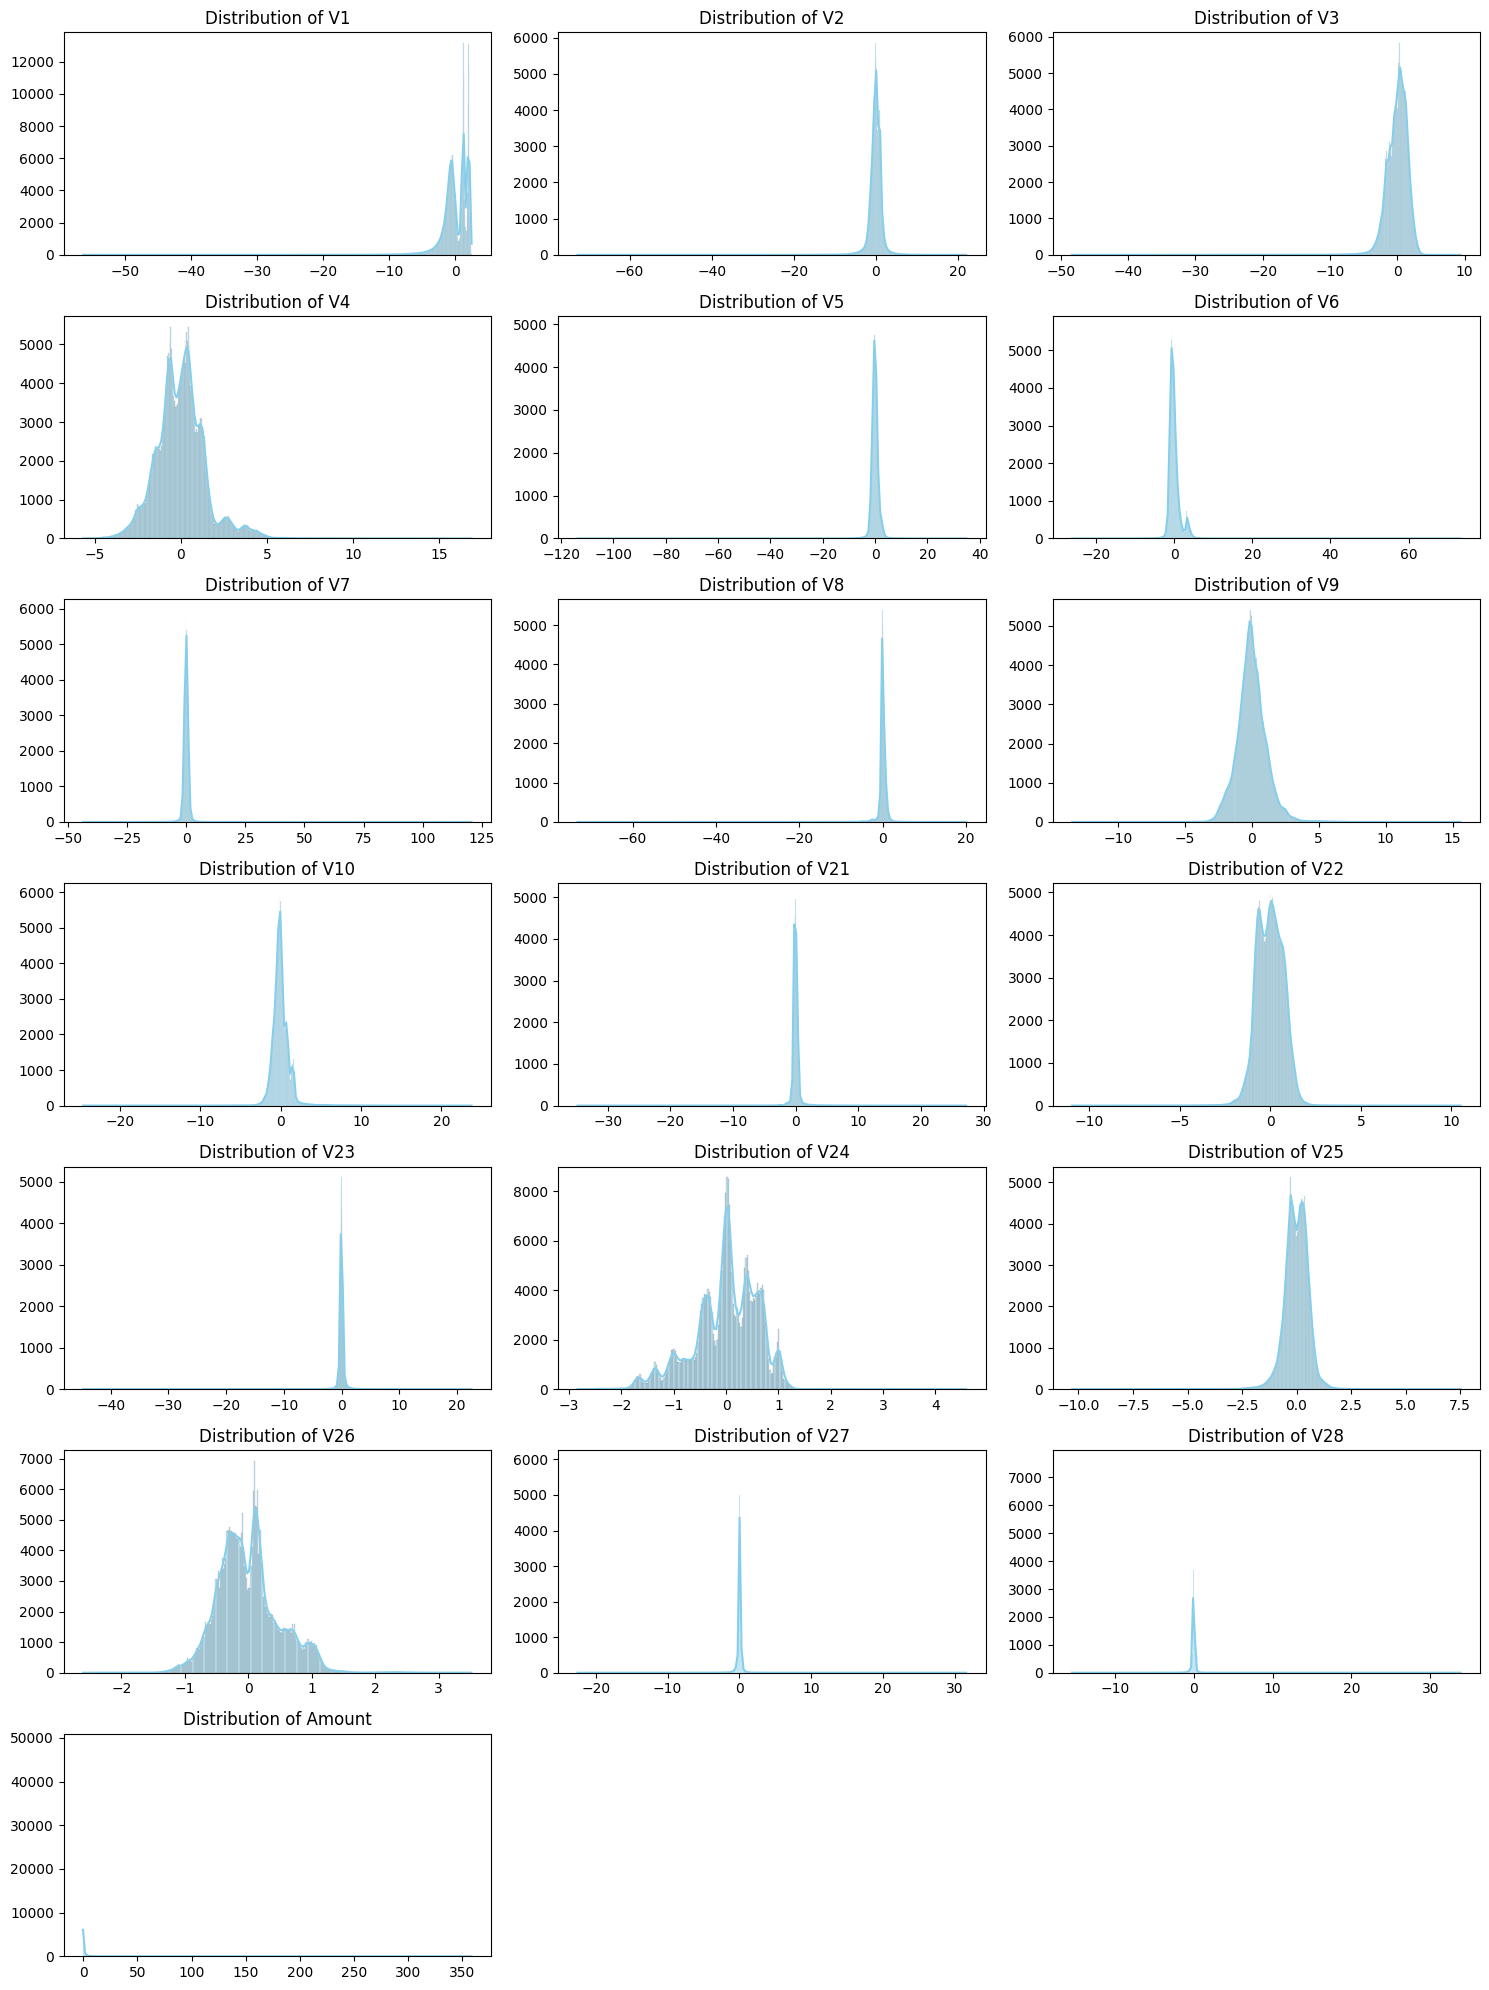

In [ ]:
# Выбор числовых признаков
numeric_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
                    'V10', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
                    'V28', 'Amount']

# Визуализация гистограмм
def plot_histograms(data, columns):
    fig, axes = plt.subplots(nrows=len(columns) // 3 + 1, ncols=3, figsize=(15, 20))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        sns.histplot(data[column], kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Удаление пустых графиков
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Построение гистограмм
plot_histograms(data, numeric_features)

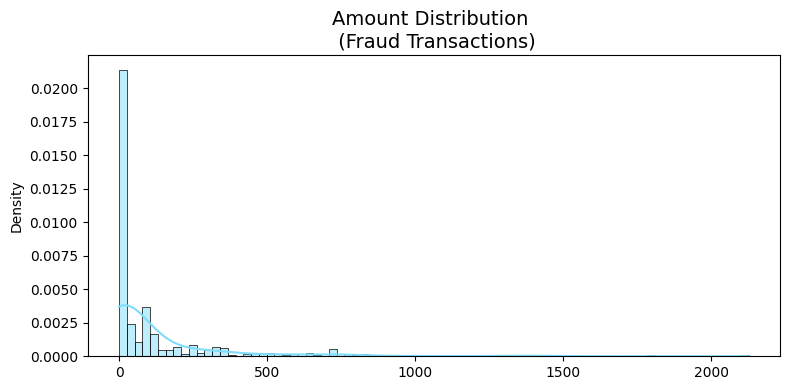

In [ ]:
# Создание подграфиков
f, ax = plt.subplots(1, 1, figsize=(8, 4))

# Данные для мошеннических транзакций
am_fraud_dist = data['Amount'].loc[data['Class'] == 1].values

sns.histplot(am_fraud_dist, ax=ax, kde=True, color='#7fddfa', stat='density')
ax.set_title('Amount Distribution \n (Fraud Transactions)', fontsize=14)

# Отображение графиков
plt.tight_layout()
plt.show()

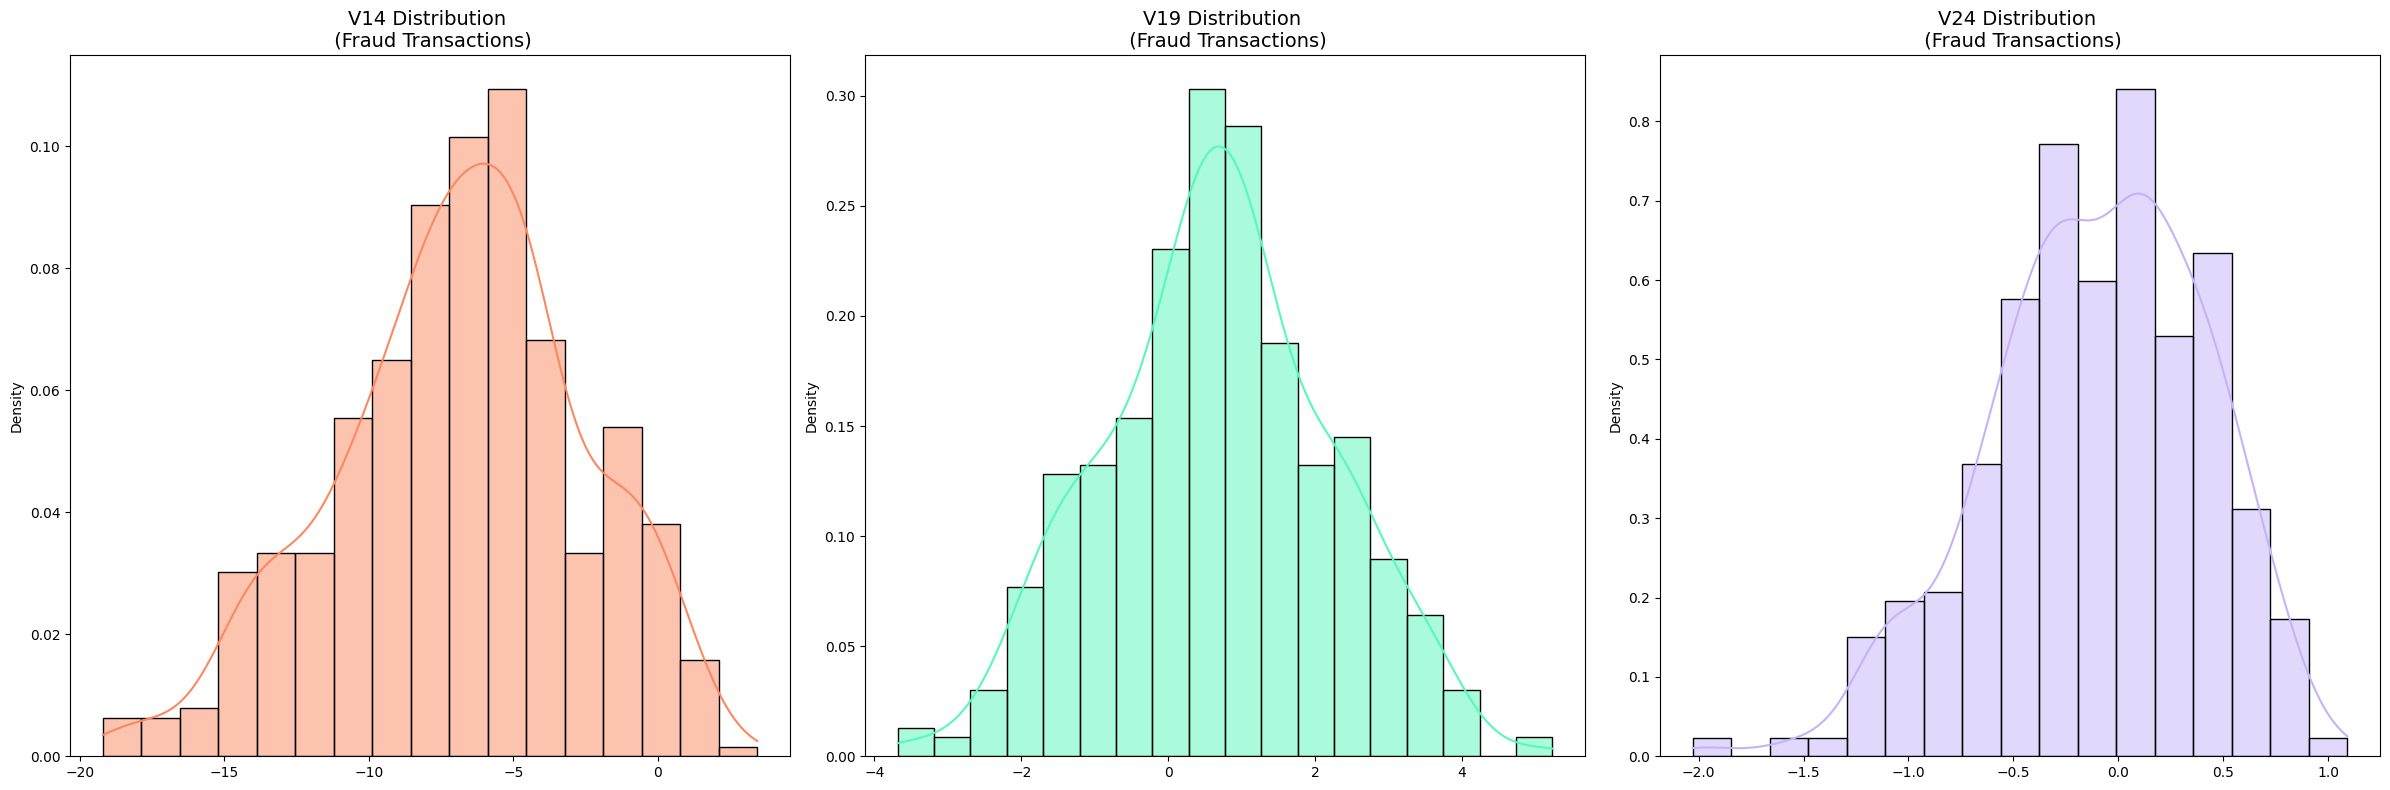

In [ ]:
# Создание подграфиков
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Данные для мошеннических транзакций
v14_fraud_dist = data['V14'].loc[data['Class'] == 1].values
v19_fraud_dist = data['V19'].loc[data['Class'] == 1].values
v24_fraud_dist = data['V24'].loc[data['Class'] == 1].values

# График для V14
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, color='#FB8861', stat='density')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

# График для V19
sns.histplot(v19_fraud_dist, ax=ax2, kde=True, color='#56F9BB', stat='density')
ax2.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

# График для V24
sns.histplot(v24_fraud_dist, ax=ax3, kde=True, color='#C5B3F9', stat='density')
ax3.set_title('V24 Distribution \n (Fraud Transactions)', fontsize=14)

# # График для V17
# sns.histplot(v17_fraud_dist, ax=ax4, kde=True, color='#ffc0cb', stat='density')
# ax4.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

# Отображение графиков
plt.tight_layout()
plt.show()

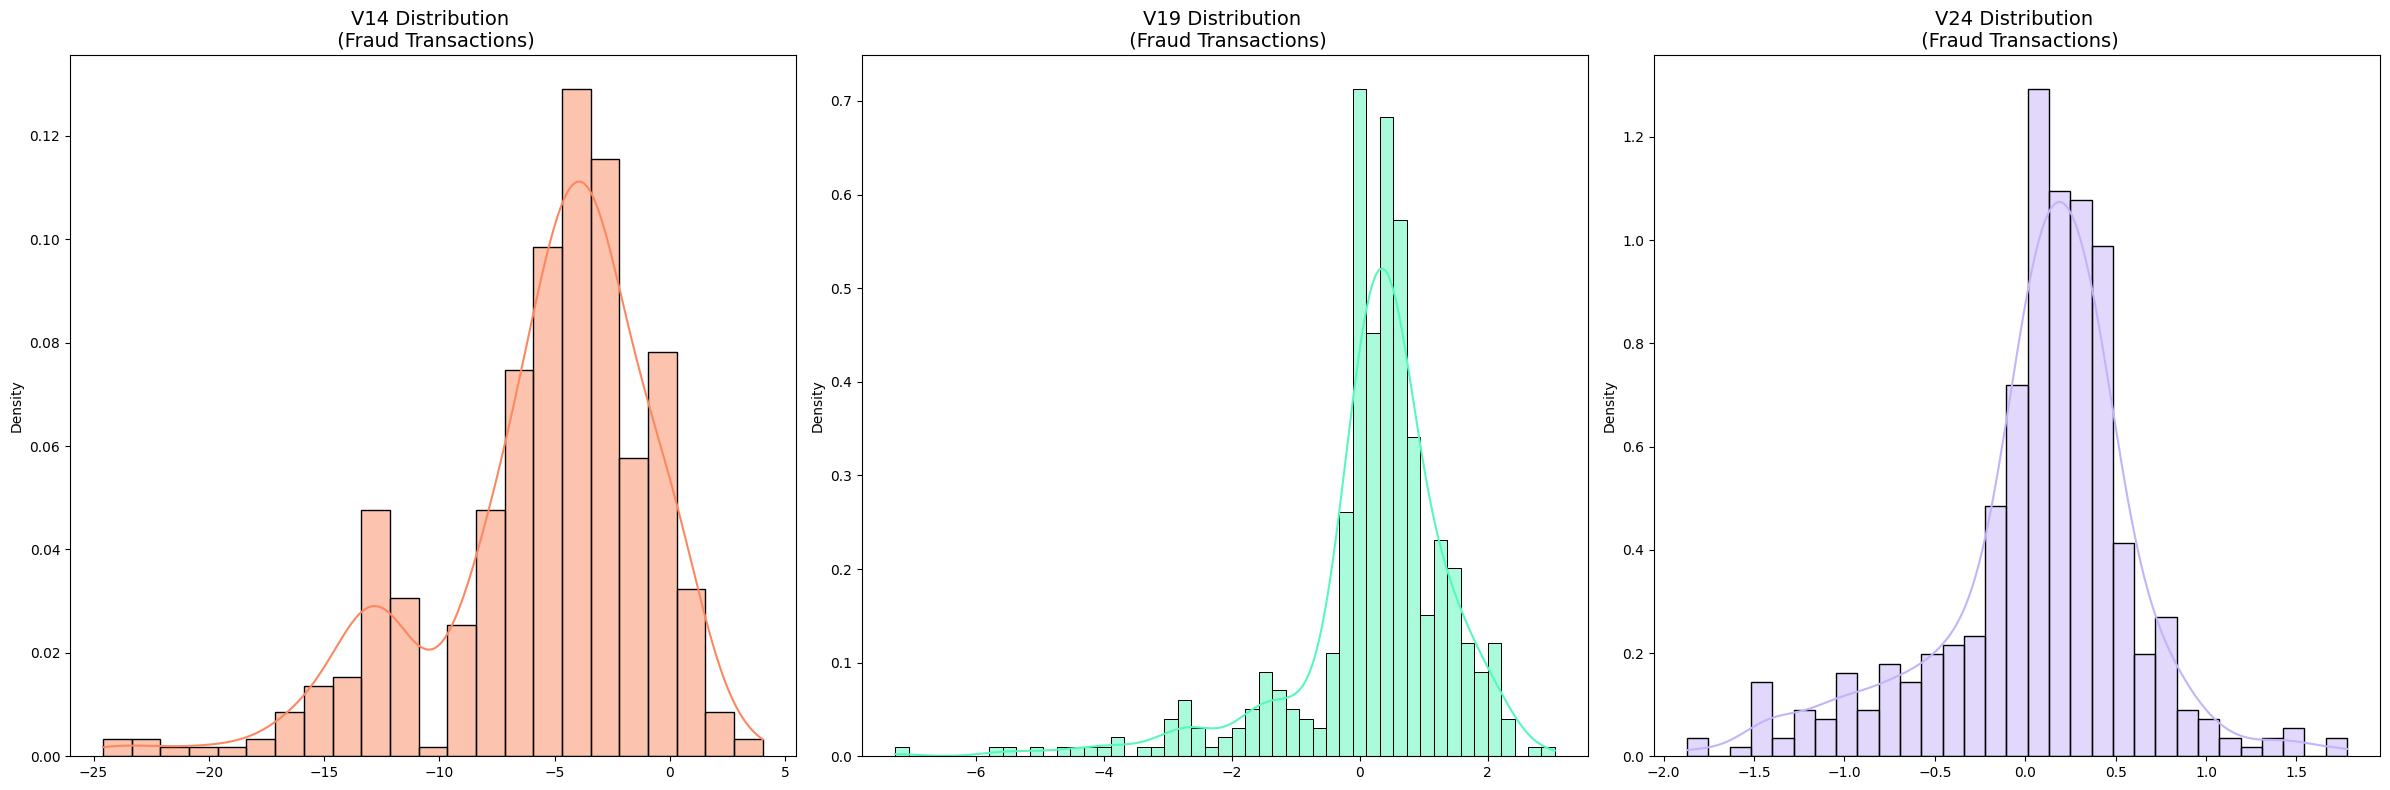

In [ ]:
# Создание подграфиков
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Данные для мошеннических транзакций
v14_fraud_dist = data['V10'].loc[data['Class'] == 1].values
v19_fraud_dist = data['V27'].loc[data['Class'] == 1].values
v24_fraud_dist = data['V28'].loc[data['Class'] == 1].values

# График для V14
sns.histplot(v14_fraud_dist, ax=ax1, kde=True, color='#FB8861', stat='density')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

# График для V19
sns.histplot(v19_fraud_dist, ax=ax2, kde=True, color='#56F9BB', stat='density')
ax2.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

# График для V24
sns.histplot(v24_fraud_dist, ax=ax3, kde=True, color='#C5B3F9', stat='density')
ax3.set_title('V24 Distribution \n (Fraud Transactions)', fontsize=14)

# # График для V17
# sns.histplot(v17_fraud_dist, ax=ax4, kde=True, color='#ffc0cb', stat='density')
# ax4.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

# Отображение графиков
plt.tight_layout()
plt.show()

### Обнаружение дубликатов

In [ ]:
data.duplicated().sum()

np.int64(1081)

In [ ]:
data[data['Class']==1].duplicated().sum()

np.int64(19)

### Распределение целевого признака (дисбаланс классов)

In [ ]:
# print(pd.Series(data["Class"]).value_counts(normalize=True))
class_distribution = pd.Series(data["Class"]).value_counts(normalize=True) * 100
class_distribution = class_distribution.apply(lambda x: f"{x:.2f}%")

print(class_distribution)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


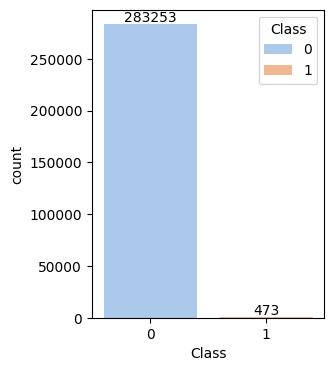

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=data,palette="pastel", hue='Class')
for i in ax.containers:
    ax.bar_label(i,)

В данной задаче наблюдается значительный дисбаланс классов. Доля миноритарного класса (например, мошеннические транзакции) составляет всего **0.172%**. Такая несбалансированность создает сложности при обучении моделей машинного обучения:

- Модели могут быть склонны к предсказанию мажоритарного класса, игнорируя миноритарный.
- Обычные метрики, такие как **Accuracy**, становятся ненадежными, так как высокая точность может быть достигнута простым предсказанием мажоритарного класса.

Чтобы справиться с этой проблемой, я буду использовать специализированные методы балансировки данных (Random Undersampling, SMOTE, Random Oversampling) и выберу метрики, которые будут адекватно отражать качество модели в условиях дисбаланса.

### Выбор метрик оценки качества модели

Для задач с дисбалансом классов стандартные метрики, такие как **Accuracy**, неинформативны. Я буду использовать следующие метрики, которые лучше подходят для оценки производительности модели:

1. **Precision:**
   - Доля правильно предсказанных положительных классов среди всех предсказанных как положительные.
   - Важна для минимизации ложных срабатываний (False Positives).

2. **Recall:**
   - Доля правильно предсказанных положительных классов среди всех реальных положительных классов.
   - Важна для минимизации пропущенных случаев (False Negatives).

3. **F1-Score:**
   - Гармоническое среднее между Precision и Recall.
   - Используется для поиска баланса между Precision и Recall.

4. **AUPRC (Area Under the Precision-Recall Curve):**
   - Площадь под кривой Precision-Recall.
   - Особенно полезна для задач с дисбалансом классов, так как фокусируется на миноритарном классе.

**AUPRC** будет использоваться как основная метрика для сравнения моделей, так как она наиболее информативна для задач с дисбалансом классов.

## Предобработка данных

### Удаление дубликатов

In [5]:
data.drop_duplicates(inplace=True)
data.shape

(283726, 31)

### Удаление признака "Time"

In [6]:
data = data.drop('Time', axis=1)

### Масштабирование числовых признаков

Попробовать масштабировать все признаки

StandardScaler
Приводит данные к стандартному нормальному распределению (среднее = 0, стандартное отклонение = 1).
Подходит для признаков с нормальным распределением (например, V1–V28).

RobustScaler
Приводит данные к медиане и межквартильному размаху (устойчив к выбросам).
Подходит для признаков с выбросами (например, Amount). V10, V27, V28, Amount!!

In [ ]:
# from sklearn.preprocessing import StandardScaler

# Выбор числовых признаков
numeric_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
                    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
                    'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
                    'V26', 'V27', 'V28']

# Масштабирование
# scaler = StandardScaler()
# scaler = RobustScaler()
# data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [7]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)

# RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# data['Amount'] = std_scaler.fit_transform(data['Amount'].values.reshape(-1,1))

data['Amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
# data['Time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

# data[['Time', 'Amount']].describe()
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.924387,0.001667
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,3.482123,0.040796
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,-0.305938,0.000000
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,-0.228063,0.000000
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.771937,0.000000
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,356.962314,1.000000


### Разделение данных на выборки

In [106]:
X = data.drop('Class', axis=1)
y = data['Class']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# # Разделение обучающих данных на обучающую и валидационную выборки
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
# )

## Dummy model
Модель, которая всегда будет предсказывать класс "мошенничество". Она будет служить отправной точкой для сравнения с более сложными моделями.

In [9]:
y_pred_dummy = [1] * len(y_test)  # Предсказания только "мошенничество"

# Оценка качества
precision, recall, _ = precision_recall_curve(y_test, y_pred_dummy)

auprc_dummy = auc(recall, precision)
f1_dummy = f1_score(y_test, y_pred_dummy)
recall_dummy = recall_score(y_test, y_pred_dummy)
prec_dummy = precision_score(y_test, y_pred_dummy)

AUPRC: 0.501
F1: 0.003
Recall: 1.000
Precision: 0.002


In [11]:
ndf = [(recall_dummy, prec_dummy, f1_dummy, auprc_dummy)]

dummy_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'AUPRC'])
dummy_score.insert(0, 'Model', 'Dummy model')
dummy_score

,Model,Recall,Precision,F1 Score,AUPRC
0,Dummy model,1.0,0.001674,0.003343,0.500837


## Обучение моделей на исходных данных

### Logistic Regression

#### Обучение модели

In [105]:
imbalanced_log = LogisticRegression(max_iter=1000)

imbalanced_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### Оценка модели

In [101]:
y_probs = imbalanced_log.predict_proba(X_test)[:, 1]
precision1, recall1, _ = precision_recall_curve(y_test, y_probs)
auprc_imbalanced_log = auc(recall1, precision1)

In [102]:
test_pred = imbalanced_log.predict(X_test)
f1_imbalanced_log = f1_score(y_test, test_pred)
prec_imbalanced_log = precision_score(y_test, test_pred)
recall_imbalanced_log = recall_score(y_test, test_pred)

In [ ]:
ndf = [(recall_imbalanced_log, prec_imbalanced_log, f1_imbalanced_log, auprc_imbalanced_log)]

imbalanced_log_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'AUPRC'])
imbalanced_log_score.insert(0, 'Logistic Regression', 'Imbalanced Data Model')
imbalanced_log_score

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall1[:-1], precision1[:-1], label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### Random Forest

#### Обучение модели

In [107]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,       # Количество деревьев в лесу
    max_depth=None,         # Максимальная глубина дерева (None = без ограничений)
    random_state=42,        # Для воспроизводимости результатов
    class_weight='balanced' # Учет дисбаланса классов
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### Оценка модели

In [108]:
test_pred = rf_model.predict(X_test)
f1_imbalanced_f = f1_score(y_test, test_pred)
prec_imbalanced_f = precision_score(y_test, test_pred)
recall_imbalanced_f = recall_score(y_test, test_pred)

In [109]:
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, y_pred_proba)
auprc_imbalanced_f = auc(recall2, precision2)

AUPRC: 0.818


In [ ]:
ndf = [(recall_imbalanced_f, prec_imbalanced_f, f1_imbalanced_f, auprc_imbalanced_f)]

imbalanced_log_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'AUPRC'])
imbalanced_log_score.insert(0, 'Random Forest', 'Imbalanced Data Model')
imbalanced_log_score

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall2[:-1], precision2[:-1], label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Обучение моделей на сбалансированных данных

### Random Oversampling


#### Балансировка данных

In [111]:
ros = RandomOverSampler(random_state=42)

X_over, y_over = ros.fit_resample(X_train, y_train)

In [113]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 226602 / 50.0 % of the dataset
Frauds: 226602 / 50.0 % of the dataset


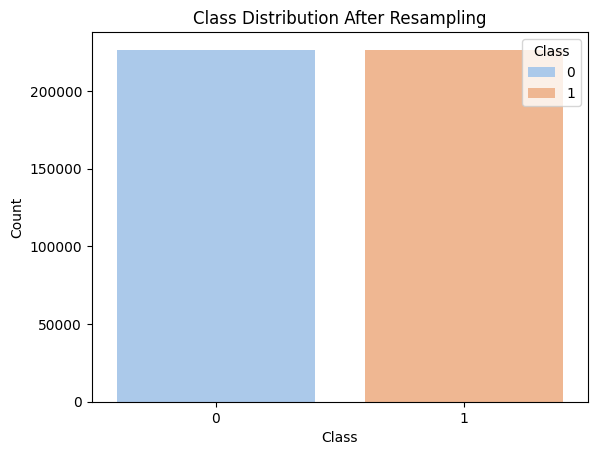

In [122]:
sns.countplot(x=y_over, palette='pastel', hue=y_over)
plt.title("Class Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Logistic Regression

##### Обучение модели

##### Оценка модели

#### Random Forest

##### Обучение модели

##### Оценка модели

#### Создание модели

In [31]:
rand_over = LogisticRegression(max_iter=1000)

rand_over.fit(X_over, y_over)

LogisticRegression(max_iter=1000)

In [73]:
y_probs = rand_over.predict_proba(X_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, y_probs)
auprc_randover = auc(recall2, precision2)

In [33]:
test_pred = rand_over.predict(X_test)
f1_randover = f1_score(y_test, test_pred)
prec_randover = precision_score(y_test, test_pred)
recall_randover = recall_score(y_test, test_pred)

#### Итоговая оценка модели

In [ ]:
# y_proba = grid_search.predict_proba(X_test)[:, 1]
# y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
# f1_randover = f1_score(y_test, y_pred_optimal)
# prec_randover = precision_score(y_test, y_pred_optimal)
# recall_randover = recall_score(y_test, y_pred_optimal)
# print("F1 Score for test with Optimal Threshold:", f1_randover)
# print("Precision Score for test with Optimal Threshold:", prec_randover)
# print("Recall Score for test with Optimal Threshold:", recall_randover)

In [ ]:
# # Вычисление AUPRC
# precision2, recall2, _ = precision_recall_curve(y_test, y_proba)
# auprc = auc(recall2, precision2)
# print("AUPRC:", auprc)

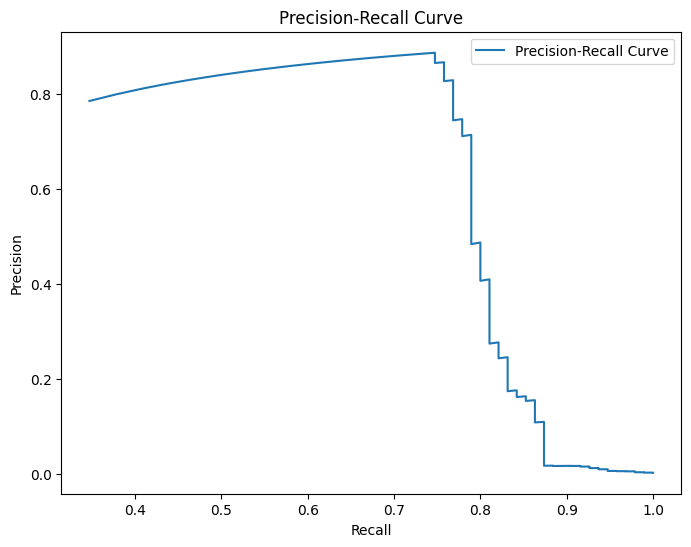

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(recall2[:-1], precision2[:-1], label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [47]:
# # rand_over.fit(X_over, y_over)
# test_pred = grid_search.predict(X_test)
# precision, recall, _ = precision_recall_curve(y_test, test_pred)

# auprc_randover = auc(recall, precision)
# f1_randover = f1_score(y_test, test_pred)
# prec_randover = precision_score(y_test, test_pred)
# recall_randover = recall_score(y_test, test_pred)
# print(f'auprc: {auprc_randover}')
# print(f'f1: {f1_randover}')

auprc: 0.46512163456428324
f1: 0.10586734693877552


In [39]:
ndf = [(recall_randover, prec_randover, f1_randover, auprc_randover)]

randover_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'AUPRC'])
randover_score.insert(0, 'Model', 'Random Oversampling')
randover_score

,Model,Recall,Precision,F1 Score,AUPRC
0,Random Oversampling,0.873684,0.056424,0.106003,0.704728


### SMOTE
Логистическая регрессия, обученная на данных, сгенерированных с помощью SMOTE
(Synthetic Minority Oversampling Technique).

#### Балансировка данных

In [47]:
smt= SMOTE(random_state=42)
X_smote, y_smote = smt.fit_resample(X_train, y_train)


In [63]:
print('Genuine:', y_smote.value_counts()[0], '/', round(y_smote.value_counts()[0]/len(y_smote) * 100,2), '% of the dataset')
print('Frauds:', y_smote.value_counts()[1], '/',round(y_smote.value_counts()[1]/len(y_smote) * 100,2), '% of the dataset')

Genuine: 226602 / 50.0 % of the dataset
Frauds: 226602 / 50.0 % of the dataset


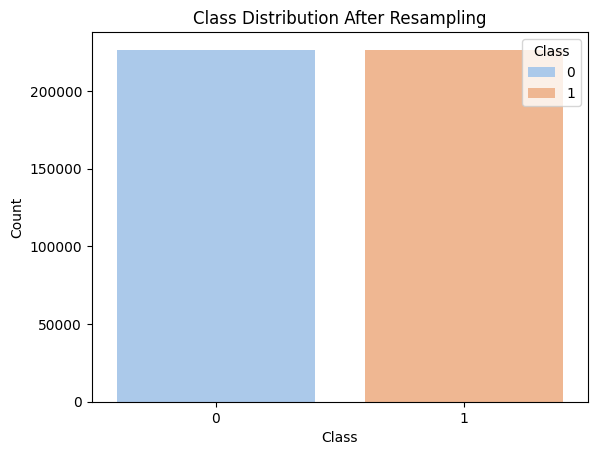

In [123]:
sns.countplot(x=y_smote, palette='pastel', hue=y_smote)
plt.title("Class Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Logistic Regression

##### Обучение модели

##### Оценка модели

#### Random Forest

##### Обучение модели

##### Оценка модели

#### Создание модели

In [48]:
smote = LogisticRegression(random_state=42, max_iter=1000)
smote.fit(X_smote, y_smote)

LogisticRegression(max_iter=1000, random_state=42)

In [75]:
y_probs = smote.predict_proba(X_test)[:, 1]
precision3, recall3, _ = precision_recall_curve(y_test, y_probs)
auprc_smote = auc(recall3, precision3)

In [50]:
test_pred = rand_over.predict(X_test)
f1_smote = f1_score(y_test, test_pred)
prec_smote = precision_score(y_test, test_pred)
recall_smote = recall_score(y_test, test_pred)

#### Итоговая оценка модели

In [ ]:
# y_proba = grid_search.predict_proba(X_test)[:, 1]
# y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
# f1 = f1_score(y_test, y_pred_optimal)
# precision = precision_score(y_test, y_pred_optimal)
# recall = recall_score(y_test, y_pred_optimal)
# print("F1 Score for test with Optimal Threshold:", f1)
# print("Precision Score for test with Optimal Threshold:", precision)
# print("Recall Score for test with Optimal Threshold:", recall)

F1 Score for test with Optimal Threshold: 0.06207928197456993
Precision Score for test with Optimal Threshold: 0.03218301667312912
Recall Score for test with Optimal Threshold: 0.8736842105263158


In [ ]:
# # Вычисление AUPRC
# precision3, recall3, _ = precision_recall_curve(y_test, y_proba)
# auprc = auc(recall3, precision3)
# print("AUPRC:", auprc)

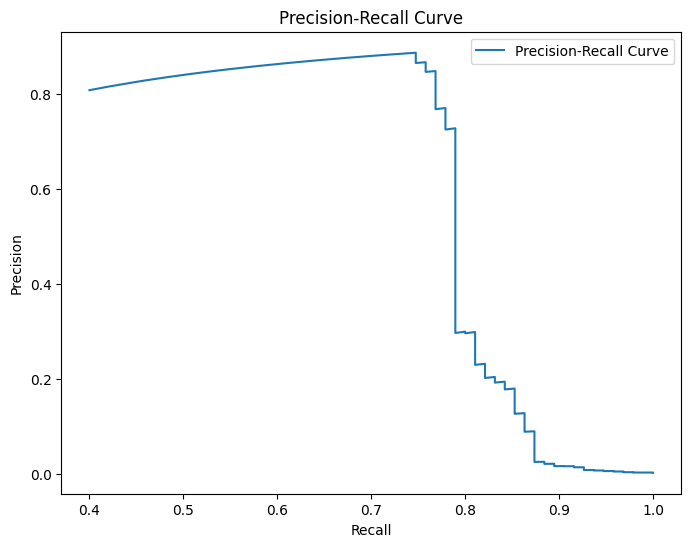

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(recall3[:-1], precision3[:-1], label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [28]:
# smote.fit(X_smote, y_smote)
# test_pred = smote.predict(X_test)
# precision, recall, _ = precision_recall_curve(y_test, test_pred)

# auprc_smote = auc(recall, precision)
# f1_smote = f1_score(y_test, test_pred)
# prec_smote = precision_score(y_test, test_pred)
# recall_smote = recall_score(y_test, test_pred)

In [52]:
ndf = [(recall_smote, prec_smote, f1_smote, auprc_smote)]

smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'AUPRC'])
smote_score.insert(0, 'Model', 'SMOTE')
smote_score

,Model,Recall,Precision,F1 Score,AUPRC
0,SMOTE,0.873684,0.056424,0.106003,0.710724


### Random Undersampling
Логистическая регрессия, обученная на данных, сгенерированных с помощью Random Undersampling

#### Балансировка данных

In [54]:
# Балансировка обучающих данных
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [ ]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 378 / 50.0 % of the dataset
Frauds: 378 / 50.0 % of the dataset


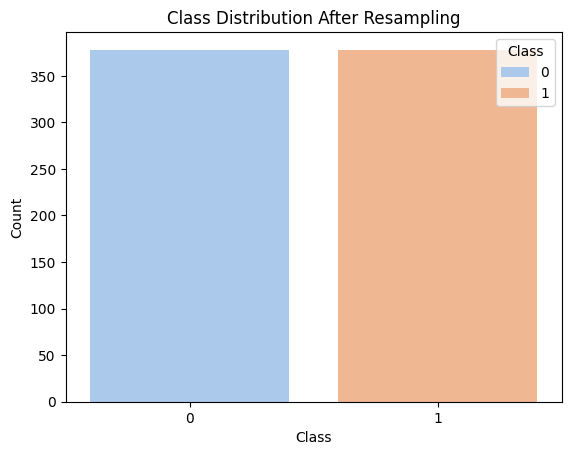

In [124]:
sns.countplot(x=y_under, palette='pastel', hue=y_under)
plt.title("Class Distribution After Resampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Logistic Regression

##### Обучение модели

##### Оценка модели

#### Random Forest

##### Обучение модели

##### Оценка модели

#### Создание модели

In [56]:
rand_under = LogisticRegression(max_iter=1000)
rand_under.fit(X_under, y_under)

LogisticRegression(max_iter=1000)

In [77]:
y_probs = rand_under.predict_proba(X_test)[:, 1]
precision4, recall4, _ = precision_recall_curve(y_test, y_probs)
auprc_randunder = auc(recall4, precision4)

In [58]:
test_pred = rand_under.predict(X_test)
f1_randunder = f1_score(y_test, test_pred)
prec_randunder = precision_score(y_test, test_pred)
recall_randunder = recall_score(y_test, test_pred)

#### Итоговая оценка модели

In [61]:
# pred = grid_search.predict(X_test)
# print(f"F1: {f1_score(y_test, pred):.3f}")
# print(f"Recall: {recall_score(y_test, pred):.3f}")
# print(f"Precision: {precision_score(y_test, pred):.3f}")

F1: 0.106
Recall: 0.874
Precision: 0.056


In [ ]:
# y_proba = grid_search.predict_proba(X_test)[:, 1]
# precision4, recall4, _ = precision_recall_curve(y_test, y_proba)
# auprc = auc(recall4, precision4)
# print("AUPRC:", auprc)

AUPRC: 0.5674728082981098


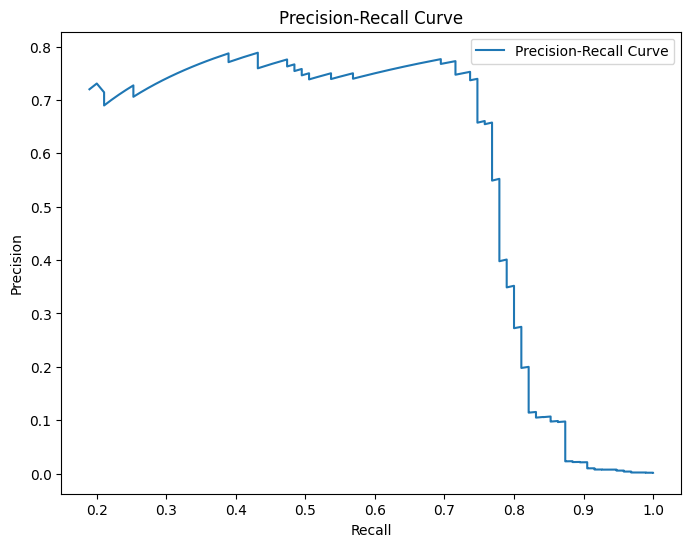

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(recall4[:-1], precision4[:-1], label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [32]:
# rand_under.fit(X_under, y_under)
# test_pred = rand_under.predict(X_test)
# precision, recall, _ = precision_recall_curve(y_test, test_pred)

# auprc_randunder = auc(recall, precision)
# f1_randunder = f1_score(y_test, test_pred)
# prec_randunder = precision_score(y_test, test_pred)
# recall_randunder = recall_score(y_test, test_pred)

In [60]:
ndf = [(recall_randunder, prec_randunder, f1_randunder, auprc_randunder)]

randunder_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'AUPRC'])
randunder_score.insert(0, 'Model', 'Random Undersampling')
randunder_score

,Model,Recall,Precision,F1 Score,AUPRC
0,Random Undersampling,0.873684,0.050242,0.09502,0.62172


## Сравнение моделей

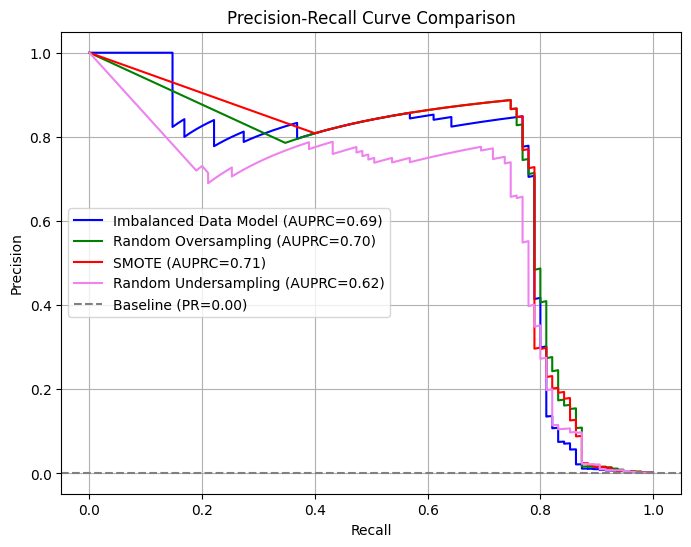

In [81]:
# Создание графика
plt.figure(figsize=(8, 6))
plt.plot(recall1, precision1, label=f'Imbalanced Data Model (AUPRC={auprc_base:.2f})', color='blue')
plt.plot(recall2, precision2, label=f'Random Oversampling (AUPRC={auprc_randover:.2f})', color='green')
plt.plot(recall3, precision3, label=f'SMOTE (AUPRC={auprc_smote:.2f})', color='red')
plt.plot(recall4, precision4, label=f'Random Undersampling (AUPRC={auprc_randunder:.2f})', color='violet')


# Базовый уровень
baseline = y_test.mean()
plt.axhline(baseline, linestyle='--', color='gray', label=f'Baseline (PR={baseline:.2f})')

# Настройка графика
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
results = pd.concat([dummy_score, base_score, randover_score, smote_score, randunder_score], ignore_index=True, sort=False)
results = results.sort_values(by=['AUPRC'], ascending=True)
results

,Model,Recall,Precision,F1 Score,AUPRC
0,Dummy model,1.000000,0.001674,0.003343,0.500837
4,Random Undersampling,0.873684,0.050242,0.095020,0.621720
1,Imbalanced Data Model,0.578947,0.846154,0.687500,0.690047
2,Random Oversampling,0.873684,0.056424,0.106003,0.704728
3,SMOTE,0.873684,0.056424,0.106003,0.710724


## Сохранение модели/моделей

## Старый код

In [ ]:
new_df = pd.DataFrame(X_train_balanced, columns=X_train.columns)
new_df['Class'] = y_train_balanced.values  # Добавляем столбец с метками

new_df = new_df.sample(frac=1).reset_index(drop=True) # Перемешивание DataFrame
# Проверка нового DataFrame
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.573800,-2.044489,3.368306,-3.937111,5.623120,-3.079232,-1.253474,-5.778880,1.707428,-4.467103,...,1.483594,0.834311,-0.148486,0.001669,-0.038996,0.389526,1.300236,0.549940,-0.200111,1
1,-0.106419,1.164037,-0.679082,1.862887,0.748138,-1.695992,0.469245,-1.373619,0.259985,0.021838,...,-0.122775,0.487129,0.022861,0.423096,0.282719,-0.182673,0.148934,0.050336,-0.139202,0
2,0.440722,-0.515299,1.556084,-0.368029,4.135762,1.282154,0.657866,0.622960,-0.066090,-1.408844,...,0.220055,1.062257,-0.231188,0.108453,-1.176028,0.319177,-0.002729,-0.152123,-0.000834,0
3,0.791667,-3.576362,3.299436,-7.460433,7.783634,-0.398549,-1.968441,-3.110476,-0.328404,-1.574363,...,0.540731,0.719526,0.379249,-0.616962,-0.442811,0.359841,-2.651825,0.422184,-0.292032,1
4,-0.136491,-1.142764,1.083543,2.495549,3.084072,-1.230109,0.953409,-0.182130,0.885256,-0.973829,...,-0.028772,-0.098114,0.108054,0.507914,0.066198,0.182436,0.206675,0.095907,1.114588,0


In [104]:
def remove_outliers(v, v_name, coef, new_df):
  print(f'                       {v_name}')
  q25, q75 = np.percentile(v, 25), np.percentile(v, 75)
  print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
  iqr = q75 - q25
  print('iqr: {}'.format(iqr))

  cut_off = iqr * coef
  lower, upper = q25 - cut_off, q75 + cut_off
  print('Cut Off: {}'.format(cut_off))
  print(f'{v_name} Lower: {lower}')
  print(f'{v_name} Upper: {upper}')

  outliers = [x for x in v if x < lower or x > upper]
  print(f'Feature {v_name} Outliers for Fraud Cases: {len(outliers)}')
  # # print('V10 outliers:{}'.format(outliers))
  new_df = new_df.drop(new_df[(new_df[f'{v_name}'] > upper) | (new_df[f'{v_name}'] < lower)].index)
  print('-' * 70)
  return new_df

coef = 1.5

# -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 0].values
new_df = remove_outliers(v14_fraud, 'V14', coef, new_df)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 0].values
new_df = remove_outliers(v12_fraud, 'V12', coef, new_df)

# -----> V10 removing outliers from fraud transactions
v10_fraud = new_df['V10'].loc[new_df['Class'] == 0].values
new_df = remove_outliers(v10_fraud, 'V10', coef, new_df)

# -----> V17 removing outliers from fraud transactions
v17_fraud = new_df['V17'].loc[new_df['Class'] == 0].values
new_df = remove_outliers(v17_fraud, 'V17', coef, new_df)


                       V14
Quartile 25: -0.4158006859524695 | Quartile 75: 0.491728192794869
iqr: 0.9075288787473386
Cut Off: 1.3612933181210078
V14 Lower: -1.7770940040734773
V14 Upper: 1.8530215109158767
Feature V14 Outliers for Fraud Cases: 12818
----------------------------------------------------------------------
                       V12
Quartile 25: -0.365561536843432 | Quartile 75: 0.62506721394912
iqr: 0.990628750792552
Cut Off: 1.485943126188828
V12 Lower: -1.85150466303226
V12 Upper: 2.1110103401379483
Feature V12 Outliers for Fraud Cases: 12400
----------------------------------------------------------------------
                       V10
Quartile 25: -0.49004674923557 | Quartile 75: 0.46299182302911
iqr: 0.95303857226468
Cut Off: 1.42955785839702
V10 Lower: -1.91960460763259
V10 Upper: 1.89254968142613
Feature V10 Outliers for Fraud Cases: 6019
----------------------------------------------------------------------
                       V17
Quartile 25: -0.511711139569

In [ ]:
X_train_balanced = new_df.drop('Class', axis=1).values
y_train_balanced = new_df['Class'].values

In [ ]:
log_m = LogisticRegression(max_iter=1000)

log_m.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000)

In [ ]:
score = cross_val_score(log_m, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
print(score.mean())

score = cross_val_score(log_m, X_train, y_train, cv=5, scoring='f1')
print(score.mean())

score = cross_val_score(log_m, X_test, y_test, cv=5, scoring='f1')
print(score.mean())

0.9235376830933797
0.7190638346358291
0.6207936507936507


In [ ]:
score = cross_val_score(log_m, X_train_balanced, y_train_balanced, cv=5, scoring='recall')
print(score.mean())

score = cross_val_score(log_m, X_train, y_train, cv=5, scoring='recall')
print(score.mean())

score = cross_val_score(log_m, X_test, y_test, cv=5, scoring='recall')
print(score.mean())

0.8990610328638498
0.6162105263157895
0.5263157894736842


In [ ]:
# # Let's implement simple classifiers
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# classifiers = {
#     "LogisiticRegression": LogisticRegression(),
#     "KNearest": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
#     "DecisionTreeClassifier": DecisionTreeClassifier()
# }

In [ ]:

# for key, classifier in classifiers.items():
#     classifier.fit(X_train_balanced, y_train_balanced)
#     training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')
#     # classifier.fit(X_train, y_train)
#     # training_score = cross_val_score(classifier, X_train, y_train, cv=5)
#     # training_score = cross_val_score(classifier, X, y, cv=5, scoring='f1')
#     print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% f1 score")

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.model_selection import StratifiedKFold


# X = data.drop(['Class'],axis=1)
# y = data['Class']

# sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# for train_index, test_index in sss.split(X, y):
#     print("Train:", train_index, "Test:", test_index)
#     original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
#     original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# # We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# # original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# # Check the Distribution of the labels

# print(original_Xtest.shape)

# # Turn into an array
# original_Xtrain = original_Xtrain.values
# original_Xtest = original_Xtest.values
# original_ytrain = original_ytrain.values
# original_ytest = original_ytest.values


# # # See if both the train and test label distribution are similarly distributed
# # train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
# # test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
# # print('-' * 100)

# # print('Label Distributions: \n')
# # print(train_counts_label/ len(original_ytrain))
# # print(test_counts_label/ len(original_ytest))

Train: [ 30191  30261  30275 ... 283723 283724 283725] Test: [    0     1     2 ... 56805 56806 56807]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 30191  30261  30275 ... 113535 113536 113537]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 77084  77379  79220 ... 170292 170293 170294]
Train: [     0      1      2 ... 283723 283724 283725] Test: [149302 150027 150068 ... 226999 227000 227001]
Train: [     0      1      2 ... 226999 227000 227001] Test: [212341 212365 213905 ... 283723 283724 283725]
(56745, 30)


In [ ]:
# # Lets shuffle the data before creating the subsamples
# data = data.sample(frac=1)

# # amount of fraud classes 492 rows.
# fraud_df = data.loc[data['Class'] == 1]
# non_fraud_df = data.loc[data['Class'] == 0][:492]

# normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# # Shuffle dataframe rows
# new_df = normal_distributed_df.sample(frac=1, random_state=42).reset_index(drop=True)

# new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.661363,1.847674,-0.805517,-0.635034,-0.159486,-0.049455,1.421396,-1.051262,0.597636,1.471352,...,0.262774,1.009795,0.135377,-1.619183,-0.373566,0.240156,0.051839,-0.069976,-0.056320,0
1,0.898561,-3.387601,3.977881,-6.978585,1.657766,-1.100500,-3.599487,-3.686651,1.942252,-3.065089,...,1.043587,0.262189,-0.479224,-0.326638,-0.156939,0.113807,0.354124,0.287592,-0.300654,1
2,-0.511186,-7.896886,5.381020,-8.451162,7.963928,-7.862419,-2.376820,-11.949723,5.051356,-6.912076,...,2.557944,0.926278,0.032795,0.638073,0.361887,0.444577,1.101923,0.205958,-0.284800,1
3,-0.227215,1.193916,-0.571085,0.742522,-0.014588,-0.624561,0.832162,-0.833350,0.272897,1.169425,...,-0.049502,0.207265,-0.265272,-0.679294,0.511812,1.246604,-0.028671,-0.006112,0.137811,1
4,-0.528403,-0.964567,-1.643541,-0.187727,1.158253,-2.458336,0.852222,2.785163,-0.303609,0.940006,...,0.447180,0.536204,1.634061,0.203839,0.218749,-0.221886,-0.308555,-0.164500,10.496871,1


In [ ]:
# print('Distribution of the Classes in the subsample dataset')
# print(new_df['Class'].value_counts()/len(new_df))

Distribution of the Classes in the subsample dataset
Class
0    0.509845
1    0.490155
Name: count, dtype: float64


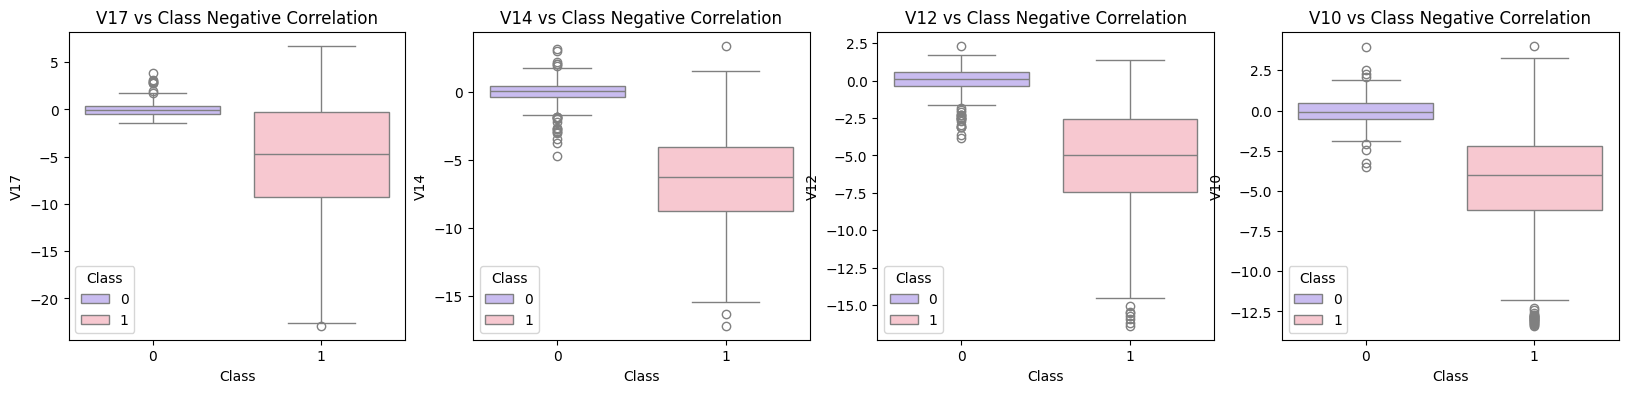

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

colors = ['#C5B3F9', '#ffc0cb']


# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0], palette=colors, hue="Class")
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1], palette=colors, hue="Class")
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2], palette=colors, hue="Class")
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3], palette=colors, hue="Class")
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

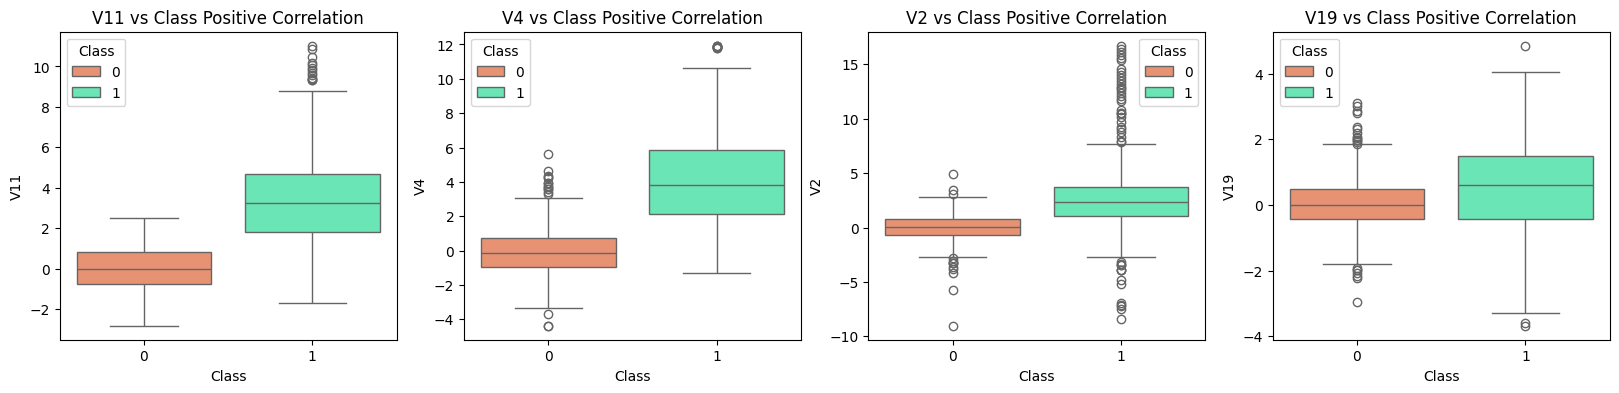

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

colors = ['#FB8861', '#56F9BB']


# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0], palette=colors, hue="Class")
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1], palette=colors, hue="Class")
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2], palette=colors, hue="Class")
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3], palette=colors, hue="Class")
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

In [ ]:
# # f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))
# f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

# colors = ['#B3F9C5', '#f9c5b3']
# # Boxplots with outliers removed
# # Feature V14
# sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors, hue="Class")
# ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
# ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
#             arrowprops=dict(facecolor='black'),
#             fontsize=14)

# # Feature 12
# sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors, hue="Class")
# ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
# ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
#             arrowprops=dict(facecolor='black'),
#             fontsize=14)

# # Feature V10
# sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors, hue="Class")
# ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
# ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
#             arrowprops=dict(facecolor='black'),
#             fontsize=14)

# # Feature V17
# sns.boxplot(x="Class", y="V17", data=new_df, ax=ax4, palette=colors, hue="Class")
# ax4.set_title("V17 Feature \n Reduction of outliers", fontsize=14)
# # ax4.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
# #             arrowprops=dict(facecolor='black'),
# #             fontsize=14)


# plt.show()

In [ ]:
# X_new = new_df.drop('Class', axis=1)
# y_new = new_df['Class']

In [ ]:
# from sklearn.model_selection import train_test_split

# # This is explicitly used for undersampling.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Turn the values into an array for feeding the classification algorithms.
# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

# X_train = X_new.values
# y_train = y_new.values